In [1]:
import qutip
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# 01: A Neutral Atom Simulator Class (Completed)

In [3]:
def computational_basis_blochs(states, colors="r"):
    """ Render each qutrit separately on a Bloch sphere, showing only the computational basis states,
        i.e. the states |0> and |1>, tracing out the Rydberg interaction state |2>.
    """
    b = qutip.Bloch()
    b.view = [60, 30]
    b.vector_color = []
    if isinstance(states, qutip.Qobj):
        states = [states]
    if states:
        for i in range(len(states[0].dims[0])):
            c = colors[i % len(colors)]
            b.vector_color.extend([c] * len(states))
            for s, alpha in zip(states, np.linspace(0.5, 1.0, len(states))):
                b.add_states(_dm3N_to_ket2(i, s), alpha=alpha)
    b.show()

def _dm3_to_ket2(s):
    """ Trace out a 3-level density matrix to a 2-level ket. """
    s = s.full()[:2, :2]
    a = np.sqrt(s[0, 0])
    b = np.sqrt(s[1, 1])
    ab = a * b
    s01 = s[0, 1]
    if ab != 0:
        phase = - np.arctan2(np.imag(s01 / ab), np.real(s01 / ab))
    else:
        if a == 0:
            return b * qutip.basis(2, 1)
        else:
            return a * qutip.basis(2, 0)
    return a * qutip.basis(2, 0) + b * np.exp(1j * phase) * qutip.basis(2, 1)


def _dm3N_to_ket2(i, s):
    """ Trace out an N-qutrit system to the 2-level ket for a single qutrit from the system. """
    s = qutip.ptrace(s, i)
    s = _dm3_to_ket2(s)
    return s

In [4]:
class NeutralAtomCircuit:
    """ A neutral atom circuit laser pulse simulator. """
    def __init__(self, atoms):
        self.n = len(atoms)
        self.atoms = atoms
        self.pulses = []
        self.t = 0

        self._a = a = qutip.basis(3, 0)
        self._b = b = qutip.basis(3, 1)
        self._r = r = qutip.basis(3, 2)

        self._ab_sx = a * b.dag() + b * a.dag()
        self._ab_sy = 1j * a * b.dag() - 1j * b * a.dag()
        self._ab_sz = b * b.dag() - a * a.dag()

        self._ar_sx = a * r.dag() + r * a.dag()

        self._rr = r * r.dag()
        self._r_coupling = 10000.

        self.H_rydberg = qutip.Qobj(dims=[[3] * self.n, [3] * self.n])
        self.rr = rr = [
            self._place_op(i, self._rr) for i in range(self.n)
        ]
        for i in range(self.n):
            for j in range(i + 1, self.n):
                self.H_rydberg += self._r_coupling * rr[i] * rr[j]

        self.pulses = []
        self.t = 0

    def state(self, s):
        """ Return a ket corresponding to the given string description. """
        states = []
        for c in s:
            if c == "0":
                q = self._a
            elif c == "1":
                q = self._b
            elif c == "+":
                q = self._a + self._b
            elif c == "-":
                q = self._a - self._b
            states.append(q.unit())
        return qutip.tensor(states)


    def _place_op(self, i, op):
        ops = [qutip.qeye(3)] * self.n
        ops[i] = op
        return qutip.tensor(ops)

    def _add_pulse(self, op, dt):
        start = self.t
        end = self.t + dt
        self.t = end
        f = lambda t, args: 1 if start <= t <= end else 0
        self.pulses.append((op, f))

    def rx(self, i, theta, dt=1):
        """ Add a laser pulse that rotates qubit i an angle theta around the X axis. """
        v = theta / dt
        O = v
        op = self._place_op(i, O * self._ab_sx)
        self._add_pulse(op, dt)

    def ry(self, i, theta, dt=1):
        """ Add a laser pulse that rotates qubit i an angle theta around the Y axis. """
        v = theta / dt
        O = v
        op = self._place_op(i, O * self._ab_sy)
        self._add_pulse(op, dt)

    def rz(self, i, theta, dt=1):
        """ Add a laser pulse that rotates qubit i an angle theta around the Z axis. """
        v = theta / dt
        O = v
        op = self._place_op(i, O * self._ab_sz)
        self._add_pulse(op, dt)

    def h(self, i):
        """ Apply a hadamard gate to qubit i. """
        # TODO

    def cz(self, control, target, dt=1):
        """ Add a pulse that performs a controlled-Z phase flip operation on two qubits. """
        v_c = (np.pi / 2) / dt
        O_c = v_c
        v_t = (2 * np.pi / 2) / dt
        O_t = v_t

        op1 = self._place_op(control, O_c * self._ar_sx)  # pi sx rotation from a -> r on control
        op2 = self._place_op(target, O_t * self._ar_sx)  # 2pi sx rotation from a -> r on target
        op3 = self._place_op(control, O_c * self._ar_sx)  # pi sx rotation from a -> r on control

        self._add_pulse(op1, dt)
        self._add_pulse(op2, dt)
        self._add_pulse(op3, dt)

    def cnot(self, i):
        """ Apply a CNOT gate to qubit i. """
        # TODO

    def run(self, psi, tlist=None, step_rate=20):
        """ Run the circuit. """
        if tlist is None:
            tlist = np.linspace(0, self.t, int(self.t * step_rate) + 1)
        if self.pulses:
            H = qutip.QobjEvo([self.H_rydberg] + self.pulses)
        else:
            H = qutip.qeye([3] * self.n)
        options = qutip.Options(nsteps=200_000)
        result = qutip.sesolve(H, psi, tlist=tlist, options=options)
        return result

# Example uses

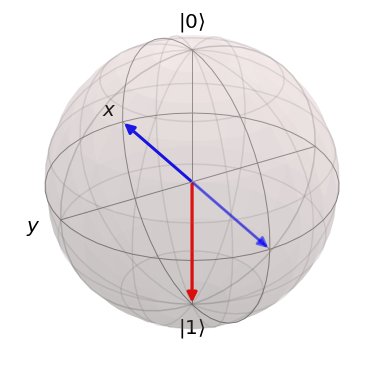

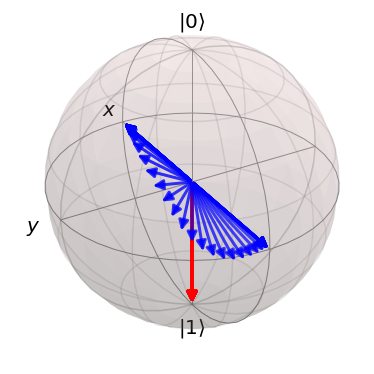

In [5]:
atoms = [(1, 0), (0, 1)]
circuit = NeutralAtomCircuit(atoms)

# Example circuit 1: Pretty sequence of rotations the form a closed loop (qubit 0)
#circuit.rx(0, np.pi / 4)
#circuit.rz(0, np.pi / 4)
#circuit.ry(0, np.pi / 4)

# Example circuit 2: Pretty sequence of rotations the form a closed loop (qubit 1)
#circuit.rx(1, -np.pi / 4)
#circuit.rz(1, -np.pi / 4)
#circuit.ry(1, -np.pi / 4)

# Example circuit 3:
# Combine the two pervious circuits into one

# Example circuit 4: Apply a CNOT
# CNOT = (I ⊗ H)CZ(I ⊗ H)
# H = X Ry(pi/2)
#circuit.rx(1, np.pi / 2)
#circuit.ry(1, np.pi / 4)
circuit.cz(0, 1)
#circuit.rx(1, np.pi / 2)
#circuit.ry(1, np.pi / 4)

psi = circuit.state("1-")
result = circuit.run(psi, step_rate=20)

# print(circuit.t, result.times)
state_idx = [0, -1]
if state_idx:
    computational_basis_blochs([result.states[i] for i in state_idx], "rb")
computational_basis_blochs(result.states, "rb")